In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy import cos, sin, exp, Matrix, sqrt
from sympy.simplify.fu import TR10, TR9
import pandas as pd

from IPython.display import display, Math
from IPython.display import display as disp
from utils import symdisp, symplot
import ipywidgets as widgets
from ipywidgets import interact

from commpy.utilities import upsample

from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp import firFilter, pulseShape, lowPassFIR, pnorm, sincInterp
from optic.metrics import signal_power
from optic.plot import eyediagram

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:,d}'.format

In [4]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
figsize(10, 4)

# Transmissão Digital da Informação

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Canal-AWGN" data-toc-modified-id="Canal-AWGN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Canal AWGN</a></span><ul class="toc-item"><li><span><a href="#Processo-estocástico-gaussiano-estacionário" data-toc-modified-id="Processo-estocástico-gaussiano-estacionário-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Processo estocástico gaussiano estacionário</a></span></li></ul></li><li><span><a href="#Relação-sinal-ruído" data-toc-modified-id="Relação-sinal-ruído-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Relação sinal-ruído</a></span></li><li><span><a href="#Referências" data-toc-modified-id="Referências-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Referências</a></span></li></ul></div>

# Sistemas de Transmissão Digital da Informação

Num sistema de comunicação digital a função do transmissor é converter uma dada sequência de bits num trem de pulsos elétricos que, por sua vez, poderar ser utilizado na modulação de uma portadora. 

<img src="./figuras/Fig1.png" width="900">
 

## Canal AWGN

Quando transmitidos pelo canal de comunicações, o sinais enviados pelo transmissor estão sujeitos a diversos tipos de distorção. Efeitos de filtragem, interferência, distorção não-linear e diversos tipos de ruído podem estar presentes no canal de comunicações, afetando a qualidade dos sinais que chegam ao receptor. 

Uma das principais fontes de ruído em sistemas de comunicações é o ruído térmico. O ruído Johnson-Nyquist (ruído térmico, ruído de Johnson ou ruído de Nyquist) é o ruído eletrônico gerado pela agitação térmica dos portadores de carga (geralmente os elétrons) dentro de um condutor elétrico, que ocorre independentemente de haver ou não tensão aplicada sobre o elemento. O ruído térmico está presente em todos os circuitos elétricos e eletrônicos. A presença de ruído em circuitos eletônicos reduz a sensibilidade de receptores na detecção de sinais de potência reduzida. Alguns equipamentos eletrônicos que requerem alta sensibilidade, como receptores de telescópios de rádio, precisam ser resfriados à temperaturas criogênicas para reduzir o ruído térmico em seus circuitos.

O modelo matemático mais importante para a análise de sistemas de comunicações digitais é o modelo de ruído branco gaussiano aditivo (*additive white Gaussian noise* (AWGN), em Inglês). Nesse modelo, o ruído é representado por um processo aleatório gaussiano, ou seja, para cada instante $t$ no tempo, o ruído $n(t)$ adicionado ao sinal é dado por uma variável aleatória gaussiana de média zero e uma certa variância $\sigma^2$. 

Seja $x(t)$ o sinal enviado pelo transmissor ao canal, o modelo de canal AWGN assume que um ruído será adicionado sinal de informação durante o processo de comunicação, como indicado na equação

$$y(t) = x(t) + n(t)$$

em que $n(t)$ representa o ruído e $y(t)$ o sinal ruidoso.

### Processo estocástico gaussiano estacionário

<IPython.core.display.Math object>

<IPython.core.display.Math object>

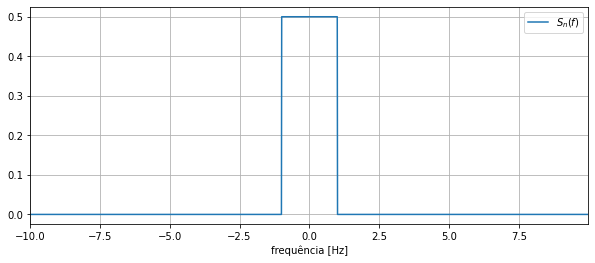

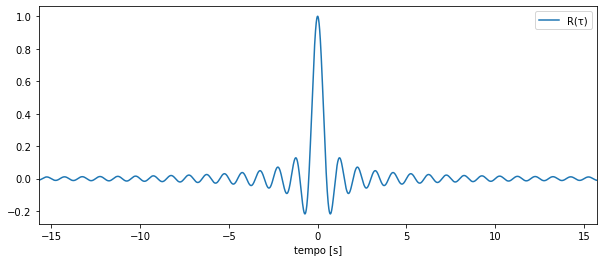

In [86]:
from sympy import fourier_transform as FT
from sympy import inverse_fourier_transform as iFT
from sympy import oo as infty

def rect(t, a):
    return (sp.Heaviside(t + a) - sp.Heaviside(t - a))

τ, f = sp.symbols('τ, f', real=True)
N0, σ , B = sp.symbols('N_0, σ, B', real=True, positive=True)

# Ruído filtrado numa banda -B < f < B:
Sn = N0/2*rect(f, B)

Rtau = iFT(Sn, f, τ)

symdisp('S_N = ', Sn)
symdisp('R(τ) = ', Rtau)

intervalo_f = np.arange(-10, 10, 0.01)
intervalo_τ = np.arange(-5*np.pi, 5*np.pi, 0.01)

symplot(f, Sn.subs({N0:1, B:1}), intervalo_f, funLabel='$S_n(f)$', xlabel= 'frequência [Hz]');
symplot(τ, Rtau.subs({N0:1,B:1}), intervalo_τ, funLabel='R(τ)');
plt.grid()

<IPython.core.display.Math object>

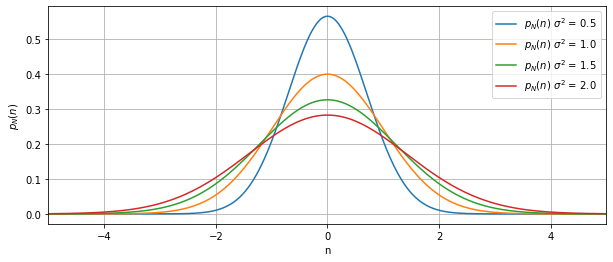

In [72]:
μ, σ, n = sp.symbols('μ, σ, n', real=True)

π = sp.pi

p = 1 / ( sp.sqrt(2*π) * σ ) * sp.exp( -(n - μ) ** 2 / ( 2*σ**2 ) )

symdisp('p_N(n) = ', p)

intervalo = np.arange(-5, 5, 0.01)
fig = None
for sigma2 in np.arange(0.5, 2.5, 0.5):
    fig = symplot(n, p.subs({μ:0, σ:np.sqrt(sigma2)}), intervalo, 
                  funLabel='$p_N(n)$ $σ^2$ = '+str(sigma2), xlabel= 'n', fig=fig);

plt.grid()
plt.ylabel('$p_N(n)$');

In [84]:
μ, σ, n = sp.symbols('μ, σ, n', real=True)

p = 1 / ( sp.sqrt(2*π) * σ ) * sp.exp( -(n - μ) ** 2 / ( 2*σ**2 ) )

sigma = 0.5

for ind in range(1, 5):
    symdisp('\int_{-'+str(ind)+'σ}^{'+str(ind)+'σ} p_N(n) dn = ', 
            sp.N(sp.integrate(p.subs({μ:0, σ:sigma}), (n, -ind*sigma, ind*sigma)),3))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

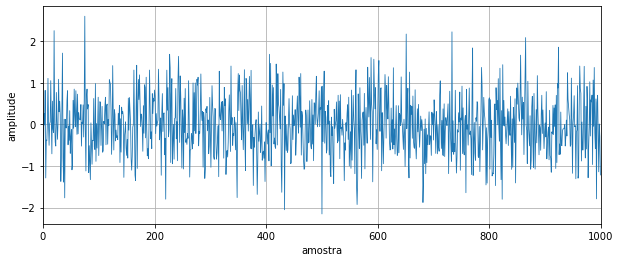

In [46]:
from numpy.random import normal

# ruído gaussiano branco
Namostras = 100000
σ2  = 0.5  # variância
μ   = 0    # média

σ      = sqrt(σ2) 
ruido  = normal(μ, σ, Namostras)  

# plotas as primeiras 1000 amostras
plt.plot(ruido[0:1000],linewidth = 0.8);
plt.xlim(0,1000)
plt.ylabel('amplitude')
plt.xlabel('amostra')
plt.grid()

Veja que o sinal ilustrado acima é a realização de um processo estocástico gaussiano estacionário. Cada amostra corresponde a uma realização de uma variável aleatória (v.a) gaussiana de média nula ($\mu=0$) e variância $\sigma^2$. As variáveis aleatórias, por sua vez, são independentes e idênticamente distribuídas (i.i.ds). Vamos calcular a potência do sinal acima, considerando que para um processo ergódico na correlação, podemos assumir:

$$P_x=E\left[X^2\right] = \mu^2 + \sigma^2\approx \frac{1}{N}\sum_{k=1}^{N} x^2[k]$$

Note que esta última expressão é a mesma expressão para cálculo da potência média de um sinal determinístico. Logo, temos que:

In [57]:
# função para calcular a potência de um sinal
def potSinal(x):
    return (x**2).mean()

print('Potência do ruído = %.2f unidades de potência' %potSinal(ruido)) # veja a definição da função potSinal() acima

Potência do ruído = 0.50 unidades de potência


## Relação sinal-ruído


A relação sinal-ruído (ou razão sinal-ruído, *signal-to-noise ratio* ($\mathrm{SNR}$), em Inglês) é uma das grandezas mais importantes na engenharia de sistemas de comunicações. A $\mathrm{SNR}$ é um indicador da presença de ruído no sistema, ou seja, a presença de distorções aleatórias e indesejáveis que afetam os sinais que carregam informação, dificultando ou impossibilitando o processo de comunicação. 

A $\mathrm{SNR}$ é definida como sendo a razão entre a potência de sinal $P_s$ e a potência do ruído $P_n$ observadas num dado sistema:

$$\mathrm{SNR} = \frac{P_s}{P_n}$$

em que $P_s = E\left[|s(t)|^2\right]$ e $P_n=E\left[|n(t)|^2\right]$, com $E[.]$ denotando valor esperado.

Quando expressa em decibéis (dB), a $\mathrm{SNR}$ é dada por

$$ \mathrm{SNR}_{dB} = 10\log_{10}P_s-10\log_{10}P_n.$$

Quanto maior a $\mathrm{SNR}$ maior a diferença entre a potência do sinal de interesse e a potência do ruído adicionado á mesma. Dessa forma, quanto maior a $\mathrm{SNR}$ melhor a qualidade do sinal.

## Referências

[1] J. G. Proakis, M. Salehi, Communication Systems Engineering, 2nd Edition, Pearson, 2002.